In [1]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor
from torch import optim
import torch
from torchvision import models, transforms
from torch import nn, transpose
from skimage import io, transform
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import tqdm

/home/swietjak/mgr/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/mnt/d/uczelnia/magister/TCGA_breast_patch/metadata.csv')

In [3]:
df.head()

,Unnamed: 0,file_name,label
0,1502,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
1,1503,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
2,1504,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
3,1505,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
4,1506,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+


In [4]:
label2id = {v: i for i, v in enumerate(df['label'].value_counts().index)}
id2label = {i: v for i, v in enumerate(df['label'].value_counts().index)}

In [5]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
class ImageDataset(Dataset):
    def __init__(self, paths, labels, label2id, transform=None):
        self.paths = paths
        self.labels = labels
        self.label2id = label2id
        self.transform = transform

    def __getitem__(self, idx):
        image = io.imread(self.paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
            
        sample = {
            'inputs': image,
            'labels': self.label2id[label]
        }
        return sample

    def __len__(self):
        return len(self.labels)

In [7]:
def get_train_test_split(df: pd.DataFrame, test_group_sample_size: int=400, train_group_sample_size: int = None, target_column: str="label"):
    test_df = pd.DataFrame(columns=df.columns)
    for c in df[target_column].unique():
        test_df = pd.concat([df[df[target_column] == c].sample(test_group_sample_size, random_state=420).loc[:], test_df.loc[:]])
    train_df = df.loc[~df.index.isin(test_df.index)]
    
    if train_group_sample_size:
        train_df2 = pd.DataFrame(columns=df.columns)
        # max_sample = np.min(df['label'].value_counts().iloc[0:3].to_numpy())
        for c in df[target_column].unique():
            train_df2 = pd.concat([df[df[target_column] == c].sample(train_group_sample_size, random_state=420).loc[:], train_df2.loc[:]])
        train_df = train_df2

    return train_df, test_df

train_df, val_df = get_train_test_split(df, train_group_sample_size=10000)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
print(train_df.shape, val_df.shape)

(30000, 4) (1200, 4)


In [8]:
# train_dataset = ImageDataset(train_df['file_name'], train_df['label'], label2id)
# val_dataset = ImageDataset(val_df['file_name'], val_df['label'], label2id)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# fig = plt.figure()

# for i, sample in enumerate(train_dataset):
#     print(i, sample['image'].shape)

#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     plt.imshow(sample['image'])

#     if i == 3:
#         plt.show()
#         break

In [9]:
class ImageClassifier(nn.Module):
    def __set_parameter_requires_grad(self, model):
        for param in model.parameters():
            param.requires_grad = False
            
    def __init__(self, num_classes):
        super(ImageClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.__set_parameter_requires_grad(self.resnet)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        
    def forward(self, input):
        input = input.float()
        out = self.resnet(input)

        return nn.functional.softmax(out, dim=1)

In [10]:
import shutil, sys   
def save_ckp(state, checkpoint_path, best_model_path=None):
    """
    state: checkpoint we want to save
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    is_best: is this the best checkpoint; min validation loss
    """
    f_path = checkpoint_path
    torch.save(state, f_path)
    
    if best_model_path is not None:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [14]:
def plot_training_stats(train_losses, valid_losses, valid_accuracies, title):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    fig.suptitle(title, fontsize=20)
    axs[0].plot(train_losses)
    axs[0].title.set_text('train losses')
    axs[1].plot(valid_losses)
    axs[1].title.set_text('valid losses')
    axs[2].plot(valid_accuracies)
    axs[2].title.set_text('valid accuracies')

    fig.savefig(f'../plots/image/{title}.png')

In [15]:
def train_model(dataloaders, num_epochs=10, lr=0.001):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    loss_fn = nn.CrossEntropyLoss()
    model = ImageClassifier(len(label2id.keys())).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    since = time.time()

    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for d in dataloaders[phase]:
                # print(inputs, labels)
                inputs = d['inputs'].to(device)
                labels = d['labels'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu())
            elif phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plot_title = f"resnet_34_{lr}"
    plot_training_stats(train_loss_history, val_loss_history, val_acc_history, plot_title)
    # load best model weights
    model.load_state_dict(best_model_wts)
    save_ckp(model, checkpoint_path=f'../checkpoints/resnet/resnet_34_{lr}.pt')
    return model, val_acc_history

  0%|          | 0/2 [00:00<?, ?it/s]/home/swietjak/mgr/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/swietjak/mgr/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------


/home/swietjak/mgr/env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train Loss: 1.0790 Acc: 0.4071
val Loss: 1.0591 Acc: 0.4400

Epoch 1/9
----------
train Loss: 1.0584 Acc: 0.4473
val Loss: 1.0472 Acc: 0.4517

Epoch 2/9
----------
train Loss: 1.0512 Acc: 0.4551
val Loss: 1.0407 Acc: 0.4767

Epoch 3/9
----------
train Loss: 1.0457 Acc: 0.4652
val Loss: 1.0374 Acc: 0.4808

Epoch 4/9
----------
train Loss: 1.0424 Acc: 0.4678
val Loss: 1.0349 Acc: 0.4908

Epoch 5/9
----------
train Loss: 1.0395 Acc: 0.4726
val Loss: 1.0331 Acc: 0.4725

Epoch 6/9
----------
train Loss: 1.0381 Acc: 0.4752
val Loss: 1.0298 Acc: 0.4825

Epoch 7/9
----------
train Loss: 1.0372 Acc: 0.4773
val Loss: 1.0288 Acc: 0.4917

Epoch 8/9
----------
train Loss: 1.0349 Acc: 0.4787
val Loss: 1.0270 Acc: 0.4850

Epoch 9/9
----------
train Loss: 1.0339 Acc: 0.4788
val Loss: 1.0259 Acc: 0.4817

Training complete in 97m 31s
Best val Acc: 0.491667


 50%|█████     | 1/2 [1:37:31<1:37:31, 5851.75s/it]

Epoch 0/9
----------
train Loss: 1.1078 Acc: 0.3344
val Loss: 1.0986 Acc: 0.3592

Epoch 1/9
----------
train Loss: 1.0996 Acc: 0.3485
val Loss: 1.0929 Acc: 0.3750

Epoch 2/9
----------
train Loss: 1.0932 Acc: 0.3691
val Loss: 1.0856 Acc: 0.3967

Epoch 3/9
----------
train Loss: 1.0879 Acc: 0.3897
val Loss: 1.0804 Acc: 0.4133

Epoch 4/9
----------
train Loss: 1.0838 Acc: 0.3987
val Loss: 1.0760 Acc: 0.4292

Epoch 5/9
----------
train Loss: 1.0796 Acc: 0.4115
val Loss: 1.0714 Acc: 0.4383

Epoch 6/9
----------
train Loss: 1.0761 Acc: 0.4188
val Loss: 1.0680 Acc: 0.4467

Epoch 7/9
----------
train Loss: 1.0733 Acc: 0.4241
val Loss: 1.0649 Acc: 0.4458

Epoch 8/9
----------
train Loss: 1.0706 Acc: 0.4262
val Loss: 1.0627 Acc: 0.4467

Epoch 9/9
----------
train Loss: 1.0692 Acc: 0.4287
val Loss: 1.0593 Acc: 0.4575

Training complete in 97m 21s
Best val Acc: 0.457500


100%|██████████| 2/2 [3:14:53<00:00, 5846.55s/it]  


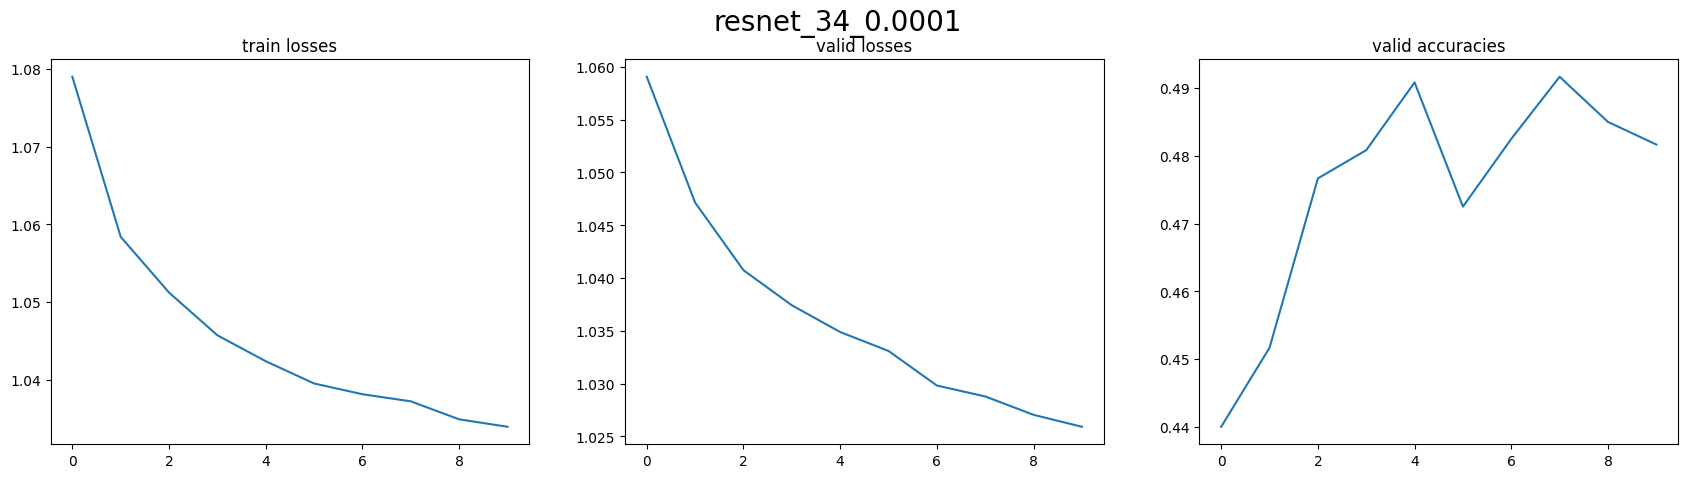

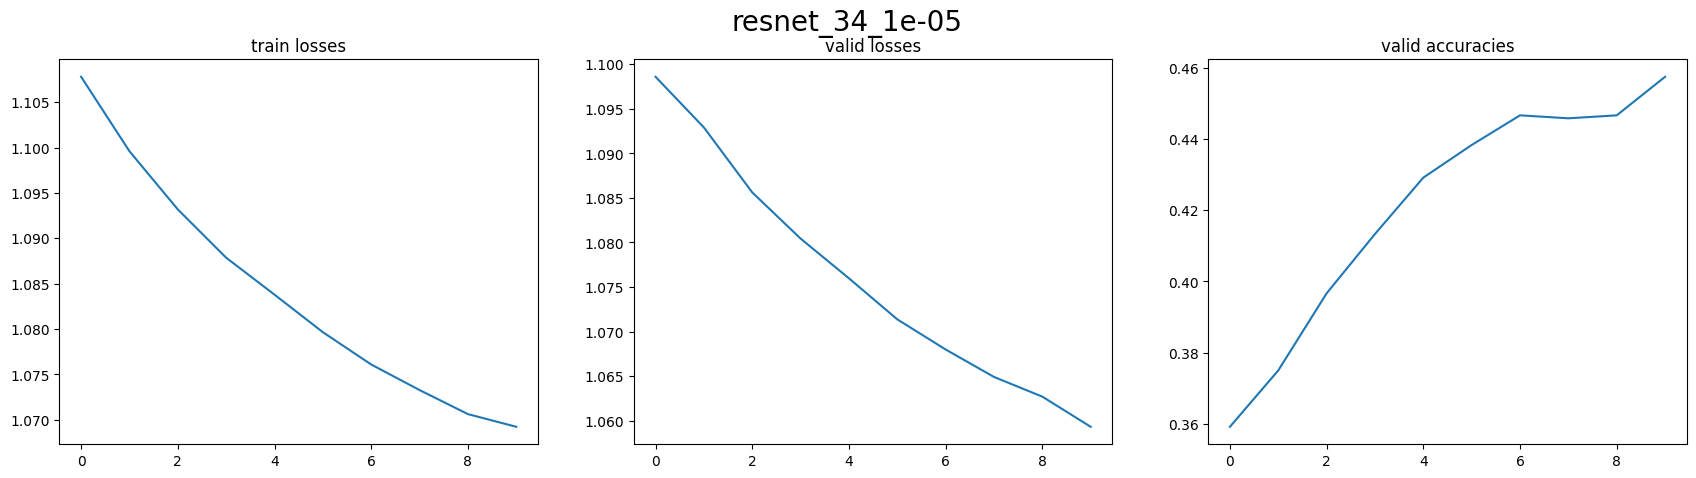

In [16]:
train_dataset = ImageDataset(train_df['file_name'], train_df['label'], label2id, data_transforms)
val_dataset = ImageDataset(val_df['file_name'], val_df['label'], label2id, data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


dataLoaders = {'val': val_loader, 'train': train_loader}
for lr in tqdm.tqdm([1e-4, 1e-5]):
    train_model(dataLoaders, lr=lr)
# model, val_acc_history = train_model(dataLoaders)

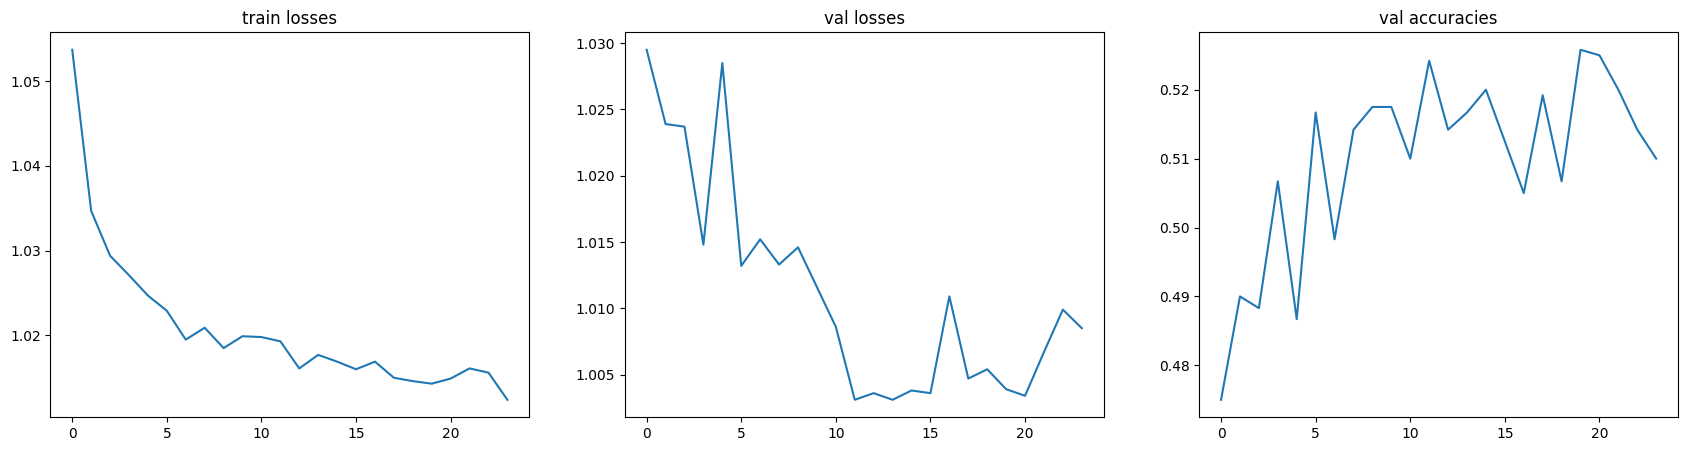

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))

axs[0].title.set_text('train losses')
axs[0].plot([1.0537,
1.0347,
1.0294,
1.0271,
1.0247,
1.0229,
1.0195,
1.0209,
1.0185,
1.0199,
1.0198,
1.0193,
1.0161,
1.0177,
1.0169,
1.0160,
1.0169,
1.0150,
1.0146,
1.0143,
1.0149,
1.0161,
1.0156,
1.0124])

axs[1].title.set_text('val losses')
axs[1].plot([1.0295,
1.0239,
1.0237,
1.0148,
1.0285,
1.0132,
1.0152,
1.0133,
1.0146,
1.0116,
1.0086,
1.0031,
1.0036,
1.0031,
1.0038,
1.0036,
1.0109,
1.0047,
1.0054,
1.0039,
1.0034,
1.0067,
1.0099,
1.0085])

axs[2].title.set_text('val accuracies')
axs[2].plot([0.4750,
0.4900,
0.4883,
0.5067,
0.4867,
0.5167,
0.4983,
0.5142,
0.5175,
0.5175,
0.5100,
0.5242,
0.5142,
0.5167,
0.5200,
0.5125,
0.5050,
0.5192,
0.5067,
0.5258,
0.5250,
0.5200,
0.5142,
0.5100])


In [ ]:
save_ckp(model, checkpoint_path='checkpoints/resnet/base_resnet.pt')